In [1]:


# def get_input_image(image, min_polygon_bbox_size=50):
#     width, height = image.size
#     while True:
#         bbox_x1 = random.randint(0, width-min_polygon_bbox_size)
#         bbox_y1 = random.randint(0, height-min_polygon_bbox_size)
#         bbox_x2 = random.randint(bbox_x1, width)  # Ensure width > 10
#         bbox_y2 = random.randint(bbox_y1, height)  # Ensure height > 10
#         if (bbox_x2-bbox_x1)<min_polygon_bbox_size or (bbox_y2-bbox_y1)<min_polygon_bbox_size:
#             continue
        
#         mask_bbox = [bbox_x1, bbox_y1, bbox_x2, bbox_y2]
#         mask_width = bbox_x2-bbox_x1
#         mask_height = bbox_y2-bbox_y1
    
#         num_points = random.randint(3,20)
#         polygon_func = random.choice([
#             random_polygon,
#             random_star_shaped_polygon,
#             random_convex_polygon
#         ])
#         polygon = polygon_func(num_points=num_points) #scaled 0~1
#         polygon = [(round(r*mask_width), round(c*mask_height)) for r,c in polygon]
#         polygon_mask = skimage.draw.polygon2mask((mask_width, mask_height), polygon)
#         if np.sum(polygon_mask)>(min_polygon_bbox_size//2)**2:
#             break
#     full_image_mask = np.zeros((width, height), dtype=np.uint8)
#     full_image_mask[bbox_x1:bbox_x2, bbox_y1:bbox_y2] = polygon_mask
    
#     image_gray = image.convert('L')
#     image_gray_array = np.array(image_gray)  # Convert to numpy array for manipulation
#     random_color = random.randint(0, 255)  # Random grayscale color
#     image_gray_array[full_image_mask == 1] = random_color
#     image_gray_masked = Image.fromarray(image_gray_array)

#     return {
#         'image_gt':image,
#         'mask':full_image_mask,
#         'image_gray':image_gray,
#         'image_gray_masked':image_gray_masked
#     }

# # 이미지 열기
# image_path = "/home/gooruem/Competition/IMGRT/train_gt/TRAIN_00000.png"  # 이미지 경로 지정
# image = Image.open(image_path)

# # 함수 호출
# result = get_input_image(image)

# import matplotlib.pyplot as plt

# # 결과 이미지 출력
# plt.figure(figsize=(10, 10))

# # 원본 이미지
# plt.subplot(2, 2, 1)
# plt.title("Original Image")
# plt.imshow(np.array(result['image_gt']))  # 수정: 원본 이미지를 넘파이 배열로 변환
# plt.axis('off')

# # 마스크
# plt.subplot(2, 2, 2)
# plt.title("Mask")
# plt.imshow(result['mask'], cmap='gray')
# plt.axis('off')

# # 그레이스케일 이미지
# plt.subplot(2, 2, 3)
# plt.title("Grayscale Image")
# plt.imshow(result['image_gray'], cmap='gray')
# plt.axis('off')

# # 마스킹된 그레이스케일 이미지
# plt.subplot(2, 2, 4)
# plt.title("Grayscale Masked Image")
# plt.imshow(result['image_gray_masked'], cmap='gray')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
import torch
import numpy as np
import os
import math
import random
import zipfile
import cv2
import numpy as np
import skimage
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
import segmentation_models_pytorch as smp

from tqdm.auto import tqdm
from glob import glob
from PIL import Image
from polygenerator import (
    random_polygon,
    random_star_shaped_polygon,
    random_convex_polygon,
)
from sklearn.model_selection import KFold
from skimage.metrics import structural_similarity as ski_ssim
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

from matplotlib import pyplot as plt

torch.set_float32_matmul_precision('medium')


pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import label

def detect_largest_mask(image_path):
    """
    Detects the largest connected mask region in a grayscale image.
    
    Args:
        image_path (str): Path to the grayscale image.

    Returns:
        np.ndarray: A binary mask containing only the largest connected mask region.
    """
    image = Image.open(image_path).convert("L")
    image_array = np.array(image)

    height, width = image_array.shape

    mask = np.zeros((height, width), dtype=np.uint8)

    offset = 1

    for y in range(height):
        for x in range(width):
            current_pixel = image_array[y, x]
            
            is_constant = True

            for dy in [-offset, 0, offset]:
                for dx in [-offset, 0, offset]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < height and 0 <= nx < width:
                        if image_array[ny, nx] != current_pixel:
                            is_constant = False
                            break
                if not is_constant:
                    break

            if is_constant:
                mask[y, x] = 1

    labeled_mask, num_features = label(mask)

    component_sizes = np.bincount(labeled_mask.flatten())
    
    component_sizes[0] = 0

    largest_component_label = component_sizes.argmax()

    largest_mask = (labeled_mask == largest_component_label).astype(np.uint8)

    return largest_mask

def process_mask(mask_image):
    mask_array = np.array(mask_image)
    mask_array = (mask_array * 255).astype(np.uint8)
    return Image.fromarray(mask_array)


inferenced_image_path = "/home/gooruem/Competition/IMGRT/submission/smp-unet-resnet152-BATCH_SIZE=8-epoch=22-val_score=0.6190/TEST_000.png"
image = Image.open(image_path)

test_input_path = "/home/gooruem/Competition/IMGRT/test_input/TEST_000.png"
mask_image = detect_largest_mask(test_input_path)
mask_image = process_mask(mask_image)
pipe.to("cuda")
prompt = "Restore the masked area with realistic details, maintaining the original style and color tone."
result = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]
result.save("./test0.png")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

NameError: name 'image_path' is not defined

  0%|          | 0/50 [00:00<?, ?it/s]

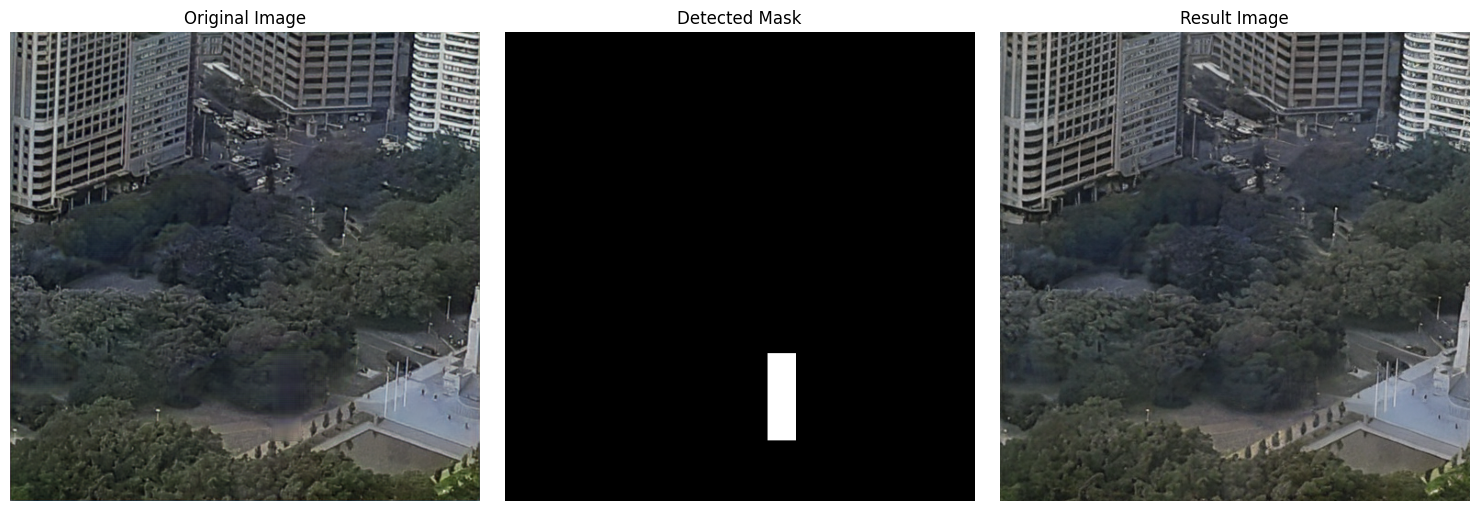

In [ ]:
from matplotlib import pyplot as plt

image_path = "/home/gooruem/Competition/IMGRT/submission/smp-unet-resnet152-BATCH_SIZE=8-epoch=22-val_score=0.6190/TEST_000.png"
image = Image.open(image_path)

test_input_path = "/home/gooruem/Competition/IMGRT/test_input/TEST_000.png"
mask_image = detect_largest_mask(test_input_path)
mask_image = process_mask(mask_image)

pipe.to("cuda")

prompt = "Restore the masked area with realistic details, maintaining the original style and color tone."
result = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]

result.save("./test0.png")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Detected Mask")
plt.imshow(mask_image, cmap="gray")  
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Result Image")
plt.imshow(result)
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
from diffusers import StableDiffusionInpaintPipeline
import torch
import numpy as np
import os
import math
import random
import zipfile
import cv2
import numpy as np
import skimage
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
import segmentation_models_pytorch as smp

from tqdm.auto import tqdm
from glob import glob
from PIL import Image
from polygenerator import (
    random_polygon,
    random_star_shaped_polygon,
    random_convex_polygon,
)
from sklearn.model_selection import KFold
from skimage.metrics import structural_similarity as ski_ssim
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

from matplotlib import pyplot as plt

def process_images_with_inpainting(inferenced_image_path, test_input_path, output_path):
    """
    Processes images using Stable Diffusion Inpainting.
    
    Args:
        inferenced_image_path (str): Path to the folder with inferred images.
        test_input_path (str): Path to the folder with original mask images.
        output_path (str): Path to save the inpainting results.

    Returns:
        None
    """
    os.makedirs(output_path, exist_ok=True)

    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        torch_dtype=torch.float16,
    )
    pipe.to("cuda")
    pipe.enable_attention_slicing()

    inferenced_files = sorted(os.listdir(inferenced_image_path))
    test_input_files = sorted(os.listdir(test_input_path))

    assert len(inferenced_files) == len(test_input_files), "Mismatch in the number of files."

    for inferred_file, mask_file in tqdm(zip(inferenced_files, test_input_files), total=len(inferenced_files)):
        inferred_path = os.path.join(inferenced_image_path, inferred_file)
        mask_path = os.path.join(test_input_path, mask_file)

        if not (inferred_file.lower().endswith(('.png', '.jpg', '.jpeg')) and mask_file.lower().endswith(('.png', '.jpg', '.jpeg'))):
            continue

        image = Image.open(inferred_path)
        mask_image = detect_largest_mask(mask_path)
        mask_image = process_mask(mask_image)

        prompt = (
            "Restore the masked area with realistic details, maintaining the original style and color tone. "
            "Use only the information around the mask to predict the masked region."
            )


        result = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]

        result.save(os.path.join(output_path, inferred_file))

inferenced_image_path = "/home/gooruem/Competition/IMGRT/submission/smp-unet-resnet152-BATCH_SIZE=8-epoch=22-val_score=0.6190/"
test_input_path = "/home/gooruem/Competition/IMGRT/test_input/"
output_path = "./result1/"

process_images_with_inpainting(inferenced_image_path, test_input_path, output_path)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]